In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

subset100 = pd.read_csv("../raw_data/track_meta_100subset_new.csv")

In [21]:
class RecommenderSystem():
    """Represents the scheme for implementing a recommender system."""
    def __init__(self, training_data, *params):
        """Initializes the recommender system. 
        
        Note that training data has to be provided when instantiating. 
        Optional parameters are passed to the underlying system.
        """
        raise NotImplementedError
        
    def train(self, *params):
        """Starts training. Passes optional training parameters to the system."""
        raise NotImplementedError
    
    def score(self, user_id, hotel_id):
        """Returns a single score for a user-hotel pair.
        
        If no prediction for the given pair can be made, an exception should be raised.
        """
        raise NotImplementedError

In [22]:
class ALSRecommenderSystem(RecommenderSystem):
    """Provides a biased ALS-based implementation of an implicit recommender system."""
    def __init__(self, training_data, biased, latent_dimension, log_dir=None, confidence=20):
        """Initializes the recommender system.
        
        Keyword arguments:
        training_data: Data to train on.
        biased: Whether to include user- and item-related biases in the model.
        latent_dimension: Dimension of the latent space.
        log_dir: Optional pointer to directory storing logging information.
        confidence: Confidence value that should be assigned to pairs where interaction 
                    was present. Since the data includes single interactions only, simply
                    assigining 1 for non-interactions and this value otherwise suffices.
                    Should be greater than 1.
        """
        self.biased = biased
        self.confidence = confidence
        self.latent_dimension = latent_dimension
        self.U = None
        self.V = None
        self.log_dir = log_dir
        self.C_users, self.P_users, self.C_items, self.P_items, self.mapping_users, self.mapping_hotels = self._build_matrices(training_data, confidence)
        self.user_dim, self.item_dim = self.P_users.shape
        
    def _build_matrices(self, activity, confidence):
        """Build the initial matrices."""
        distinct_users = len(set(activity['user']))
        distinct_hotels = len(set(activity['hotel']))
        C_users = np.ones(shape=(distinct_users, distinct_hotels))
        P_users = np.zeros(shape=(distinct_users, distinct_hotels))
        C_items = np.ones(shape=(distinct_hotels, distinct_users))
        P_items = np.zeros(shape=(distinct_hotels, distinct_users))

        mapping_users = {}
        mapping_hotels = {}
        user_ct = 0
        hotel_ct = 0

        for index, row in activity.iterrows():
            user, hotel = row
            if not user in mapping_users:
                mapping_users[user] = user_ct
                user_ct += 1
            if not hotel in mapping_hotels:
                mapping_hotels[hotel] = hotel_ct
                hotel_ct += 1
            user_index, hotel_index = mapping_users[user], mapping_hotels[hotel]
            C_users[user_index, hotel_index] = confidence
            P_users[user_index, hotel_index] = 1
            C_items[hotel_index, user_index] = confidence
            P_items[hotel_index, user_index] = 1
        return C_users, P_users, C_items, P_items, mapping_users, mapping_hotels
    
    def save(self, directory):
        """Saves current matrices to the given directory."""
        np.save(os.path.join(directory, 'U.npy'), self.U)
        np.save(os.path.join(directory, 'V.npy'), self.V)
        np.save(os.path.join(directory, 'training_data.npy'), self.training_data)
        np.save(os.path.join(directory, 'params.npy'), np.array([self.confidence]))
        if self.biased:
            np.save(os.path.join(directory, 'user_biases.npy'), self.user_biases)
            np.save(os.path.join(directory, 'item_biases.npy'), self.item_biases)
        
    def load(self, directory):
        """Loads matrices from the given directory."""
        self.U = np.load(os.path.join(directory, 'U.npy'))
        self.V = np.load(os.path.join(directory, 'V.npy'))
        self.training_data = np.load(os.path.join(directory, 'training_data.npy'))
        self.confidence = np.load(os.path.join(directory, 'params.npy')).flatten()
        if self.biased:
            self.user_biases = np.load(os.path.join(directory, 'user_biases.npy'))
            self.item_biases = np.load(os.path.join(directory, 'item_biases.npy'))
            
        self.C_users, self.P_users, self.C_items, self.P_items, self.mapping_users, self.mapping_hotels = self._build_matrices(self.training_data, self.confidence)
        self.user_dim, self.item_dim = self.P_users.shape
        
    def _single_step(self, lbd):
        """Executes a single optimization step using (biased) ALS, with lbd as regularization factor."""
        C_users, P_users, C_items, P_items, mapping_users, mapping_hotels = self.C_users, self.P_users, self.C_items, self.P_items, self.mapping_users, self.mapping_hotels
        biased = self.biased
        
        # Update U.
        if biased: # Expand matrices to account for biases.
            U_exp = np.hstack((self.user_biases.reshape(-1,1), self.U))
            V_exp = np.hstack((np.ones_like(self.item_biases).reshape(-1,1), self.V))
            kdim = self.latent_dimension + 1
        else: # We work with copies here to make it safer to abort within updates.
            U_exp = self.U.copy()
            V_exp = self.V.copy()
            kdim = self.latent_dimension
        Vt = np.dot(np.transpose(V_exp), V_exp)
        for user_index in tqdm(range(self.user_dim)):
            C = np.diag(C_users[user_index])
            d = np.dot(C, P_users[user_index] - (0 if not biased else self.item_biases))
            val = np.dot(np.linalg.inv(Vt + np.dot(np.dot(V_exp.T, C - np.eye(self.item_dim)), V_exp) + lbd*np.eye(kdim)), np.transpose(V_exp))
            U_exp[user_index] = np.dot(val, d)    
        if biased:
            self.user_biases = U_exp[:,0]
            self.U = U_exp[:,1:]
        else:
            self.U = U_exp
            
        # Update V.
        if biased:
            U_exp = np.hstack((np.ones_like(self.user_biases).reshape(-1,1), self.U))
            V_exp = np.hstack((self.item_biases.reshape(-1,1), self.V))
        else: # We work with copies here to make it safer to abort within updates.
            U_exp = self.U.copy()
            V_exp = self.V.copy()
        
        Ut = np.dot(np.transpose(U_exp), U_exp)
        for item_index in tqdm(range(self.item_dim)):
            C = np.diag(C_items[item_index])
            d = np.dot(C, P_items[item_index] - (0 if not biased else self.user_biases))
            val = np.dot(np.linalg.inv(Ut + np.dot(np.dot(U_exp.T, C-np.eye(self.user_dim)), U_exp) + lbd*np.eye(kdim)), np.transpose(U_exp))
            V_exp[item_index] = np.dot(val, d)
        if biased:
            self.item_biases = V_exp[:, 0]
            self.V = V_exp[:,1:]
        else:
            self.V = V_exp
    
    def compute_loss(self, lbd):
        """Computes loss value on the training data.
        
        Returns a tuple of total loss and prediction loss (excluding regularization loss).
        """
        C_users, P_users, C_items, P_items, mapping_users, mapping_hotels = self.C_users, self.P_users, self.C_items, self.P_items, self.mapping_users, self.mapping_hotels
        main_loss = 0
        # Main loss term.
        for user_index in range(self.user_dim):
            for item_index in range(self.item_dim):
                pred = np.dot(self.U[user_index].T, self.V[item_index])
                if self.biased:
                    pred += self.user_biases[user_index] + self.item_biases[item_index]
                loss = self.C_users[user_index, item_index] * (P_users[user_index, item_index]-pred)**2
                main_loss += loss

        # Regularization term.
        reg_loss = 0
        if lbd > 0:
            for user_index in range(self.user_dim):
                reg_loss += np.sum(self.U[user_index]**2) + (0 if not self.biased else self.user_biases[user_index]**2)
            for item_index in range(self.item_dim):
                reg_loss += np.sum(self.V[item_index]**2) + (0 if not self.biased else self.item_biases[item_index]**2)
            reg_loss *= lbd
        return main_loss + reg_loss, main_loss

    def train(self, lbd, iterations=20, verbose=True):
        """
        Trains the recommendation system.
        
        Keyword arguments:
        lbd: Regularization factor.
        iterations: Number of iterations to run ALS.
        verbose: Whether to plot and output training loss.
        """
        if self.U is None or self.V is None:
            self.U = np.random.normal(size=(self.user_dim, self.latent_dimension))
            self.V = np.random.normal(size=(self.item_dim, self.latent_dimension))
            self.user_biases = np.zeros(self.user_dim)
            self.item_biases = np.zeros(self.item_dim)
            self.history_losses = []
            self.history_main_losses = []
            self.history_avg_score = []
            self.history_avg_rank = []
        
        it = 0
        while(it < iterations):
            self._single_step(lbd) 
            loss, main_loss = self.compute_loss(lbd)
            self.history_losses.append(loss)
            self.history_main_losses.append(main_loss)
                
            if verbose:        
                clear_output(wait=True)
                print('LOSS:', loss, 'MAIN LOSS:', main_loss)
                
                plt.figure(figsize=(5,5))
                plt.title('training loss (lower is better)')
                plt.plot(range(len(self.history_losses)), self.history_losses)
                plt.plot(range(len(self.history_main_losses)), self.history_main_losses, color='orange')
                plt.plot(range(len(self.history_main_losses)), np.array(self.history_losses) - np.array(self.history_main_losses), color='green')
                plt.legend(['total loss', 'data loss', 'regularizing loss'])
                if self.log_dir is not None:
                    plt.savefig(os.path.join(self.log_dir, 'log.png'), bbox_inches='tight', format='png')
                plt.show()     
            it += 1

    def reset(self):
        """Resets the recommendation system's internal state."""
        self.U = None
        self.V = None
        
    def score(self, user_id, hotel_id):
        """Returns the scoring of hotel_id for user_id."""
        if self.U is None or self.V is None:
            raise ValueError('system has to be trained first')
        if user_id not in self.mapping_users:
            raise ValueError('user unknown')
        if hotel_id not in self.mapping_hotels:
            raise ValueError('hotel unknown')
            
        user_index = self.mapping_users[user_id]
        hotel_index = self.mapping_hotels[hotel_id]
        pred = np.dot(self.U[user_index], self.V[hotel_index])
        if self.biased: # Include applicable biases.
            pred += self.user_biases[user_index] + self.item_biases[hotel_index]
        return pred

### Train-val-test split

In [2]:
# Train-val-test split (20%)
train, test = train_test_split(subset100, test_size=0.2, random_state=42, stratify = subset100['Playlistid'])
train, val = train_test_split(train, test_size=0.2, random_state=42, stratify = train['Playlistid'])

In [3]:
test.head()

,Playlistid,Trackid,Artist_Name,Track_Name,Album_Name,Track_Duration,Artist_uri,Track_uri,Album_uri,acousticness,...,loudness,mode,speechiness,tempo,time_signature,valence,Playlist,Album,Track,Artist
557,38828,35,Bastille,Pompeii,Bad Blood,214147,spotify:artist:7EQ0qTo7fWT7DPxmxtSYEc,spotify:track:3gbBpTdY8lnQwqxNCcf795,spotify:album:64fQ94AVziavTPdnkCS6Nj,0.0755,...,-6.383,1,0.0407,127.435,4,0.571,tb,55,63,44
556,38828,34,Britney Spears,Womanizer,Circus (Deluxe Version),224400,spotify:artist:26dSoYclwsYLMAKD3tpOr4,spotify:track:4fixebDZAVToLbUCuEloa2,spotify:album:2tve5DGwub1TtbX1khPX5j,0.0730,...,-5.226,1,0.0622,139.000,4,0.235,tb,55,63,44
2414,229646,7,Soft Cell,Tainted Love,Non-Stop Erotic Cabaret,153762,spotify:artist:6aq8T2RcspxVOGgMrTzjWc,spotify:track:0cGG2EouYCEEC3xfa0tDFV,spotify:album:3KFWViJ1wIHAdOVLFTVzjD,0.4620,...,-8.284,0,0.0378,144.435,4,0.623,Throwback,121,135,91
1771,186672,28,Imagine Dragons,Radioactive,Night Visions,186813,spotify:artist:53XhwfbYqKCa1cC15pYq2q,spotify:track:6Ep6BzIOB9tz3P4sWqiiAB,spotify:album:1vAEF8F0HoRFGiYOEeJXHW,0.1190,...,-3.698,1,0.0590,136.249,4,0.210,campfire,30,34,29
516,37634,17,LANY,WHERE THE HELL ARE MY FRIENDS,WHERE THE HELL ARE MY FRIENDS,216180,spotify:artist:49tQo2QULno7gxHutgccqF,spotify:track:4TA2nSix6i8K2VV9wt6rUn,spotify:album:34ySll9UQXpSngEI0NJbFO,0.0652,...,-3.811,1,0.0344,127.994,4,0.472,not sure,16,23,13


### kNN Collaborative Filtering

In [4]:
# Create Binary Sparse Matrix
co_mat = pd.crosstab(train.Playlistid, train.Track_uri)
co_mat = co_mat.clip(upper=1)
assert np.max(co_mat.describe().loc['max']) == 1

co_mat_sparse = csr_matrix(co_mat)

In [5]:
# Train kNN model
col_filter = NearestNeighbors(metric='cosine', algorithm='brute')
col_filter.fit(co_mat_sparse)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [26]:
type(co_mat)

pandas.core.frame.DataFrame

In [27]:
M = np.array(co_mat)

In [29]:
M.shape

(100, 1534)

In [80]:
occs = []
for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        if M[i,j] == 1:
            occs.append((sorted(train.Playlistid)[i], co_mat.columns[j]))
occs = pd.DataFrame(occs, columns = ['user', 'hotel'])

In [81]:
sorted(train.Playlistid)[0]

430

In [82]:
co_mat.head()

Track_uri,spotify:track:00LfFm08VWeZwB0Zlm24AT,spotify:track:00qOE7OjRl0BpYiCiweZB2,spotify:track:01a0J96fRD91VnjQQUCqMK,spotify:track:01iyCAUm8EvOFqVWYJ3dVX,spotify:track:027h5P3kCyktHv9dpHUBBS,spotify:track:02M6vucOvmRfMxTXDUwRXu,spotify:track:03L2AoiRbWhvt7BDMx1jUB,spotify:track:03LpkqucyYKcYclDs8HuxO,spotify:track:03fT3OHB9KyMtGMt2zwqCT,spotify:track:03tqyYWC9Um2ZqU0ZN849H,...,spotify:track:7yFMhCJOsH7khgpdnyrZAZ,spotify:track:7yHEDfrJNd0zWOfXwydNH0,spotify:track:7ySUcLPVX7KudhnmNcgY2D,spotify:track:7yfg0Eer6UZZt5tZ1XdsWz,spotify:track:7yq4Qj7cqayVTp3FF9CWbm,spotify:track:7yyRTcZmCiyzzJlNzGC9Ol,spotify:track:7zBPzAjKAqQpcv8F8GCq5s,spotify:track:7zWj09xkFgA9tcV6YhfU6q,spotify:track:7zbq8RT5Kd3ExOGVTiUQbR,spotify:track:7zxRMhXxJMQCeDDg0rKAVo
Playlistid,,,,,,,,,,,,,,,,,,,,,
430,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
622,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2535,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
occs.head()

,user,hotel
0,430,spotify:track:0OuPMjmicFfmnB3SFFqdgQ
1,430,spotify:track:0TIv1rjOG6Wbc02T4p3y7o
2,430,spotify:track:1CtOCnWYfIwVgIKiR2Lufw
3,430,spotify:track:26RykSLUNpC2BymCxJgvTn
4,430,spotify:track:2VC56eybNyq2O2ahMgS6JT


In [104]:
import tqdm
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

rs = ALSRecommenderSystem(occs, True, latent_dimension=20)

LOSS: 4.671077353768185e+22 MAIN LOSS: 1.7266289624495708e+18


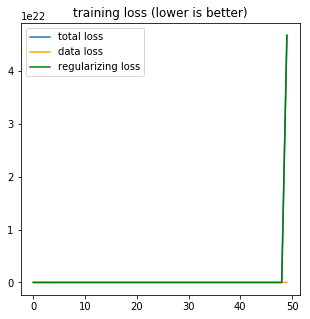

In [103]:
rs.train(0.000000001, iterations=50)

In [88]:
rs.score(430, 'spotify:track:26RykSLUNpC2BymCxJgvTn')

0.9999120816268161

In [23]:
co_mat.head()

Track_uri,spotify:track:00LfFm08VWeZwB0Zlm24AT,spotify:track:00qOE7OjRl0BpYiCiweZB2,spotify:track:01a0J96fRD91VnjQQUCqMK,spotify:track:01iyCAUm8EvOFqVWYJ3dVX,spotify:track:027h5P3kCyktHv9dpHUBBS,spotify:track:02M6vucOvmRfMxTXDUwRXu,spotify:track:03L2AoiRbWhvt7BDMx1jUB,spotify:track:03LpkqucyYKcYclDs8HuxO,spotify:track:03fT3OHB9KyMtGMt2zwqCT,spotify:track:03tqyYWC9Um2ZqU0ZN849H,...,spotify:track:7yFMhCJOsH7khgpdnyrZAZ,spotify:track:7yHEDfrJNd0zWOfXwydNH0,spotify:track:7ySUcLPVX7KudhnmNcgY2D,spotify:track:7yfg0Eer6UZZt5tZ1XdsWz,spotify:track:7yq4Qj7cqayVTp3FF9CWbm,spotify:track:7yyRTcZmCiyzzJlNzGC9Ol,spotify:track:7zBPzAjKAqQpcv8F8GCq5s,spotify:track:7zWj09xkFgA9tcV6YhfU6q,spotify:track:7zbq8RT5Kd3ExOGVTiUQbR,spotify:track:7zxRMhXxJMQCeDDg0rKAVo
Playlistid,,,,,,,,,,,,,,,,,,,,,
430,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
622,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2535,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
co_mat_sparse

<100x1534 sparse matrix of type '<class 'numpy.int64'>'
	with 1956 stored elements in Compressed Sparse Row format>

## Making Predictions

In [6]:
def nholdout(playlist_id, df):
    '''Pass in a playlist id to get number of songs held out in val/test set'''
    
    return len(df[df.Playlistid == playlist_id].Track_uri)

def kpredict(knnmodel, playlist_id, df):
    '''for a playlist id, generate list of 15*k predictions where k is num holdouts''' 
    
    k = nholdout(playlist_id, df)*15 # number of holdouts
    ref_songs = co_mat.columns.values[co_mat.loc[playlist_id] == 1] # songs already in playlist
    dist, ind = knnmodel.kneighbors(np.array(co_mat.loc[playlist_id]).reshape(1, -1), n_neighbors = 99)
    rec_ind = co_mat.index[ind[0]] # recommended playlists
    
    n_pred = 0
    pred = []
    for i in rec_ind:
        new_songs = co_mat.columns.values[co_mat.loc[i] == 1] # potential recommendations
        for song in new_songs:
            if song not in ref_songs: # only getting songs not already in target playlist
                pred.append(song)
                n_pred += 1
                if n_pred == k:
                    break
        if n_pred == k:
            break
    
    return pred

In [7]:
### Prediction Example
pi = 430 # target playlist index
kpreds = kpredict(col_filter, pi, val) # list of predictions

In [20]:
kpreds

['spotify:track:047fCsbO4NdmwCBn8pcUXl',
 'spotify:track:12d5QFwzh60IIHlsSnAvps',
 'spotify:track:1ID1QFSNNxi0hiZCNcwjUC',
 'spotify:track:1Ser4X0TKttOvo8bgdytTP',
 'spotify:track:1cdC9TCqyLwAlsw3fVJaJS',
 'spotify:track:5InOp6q2vvx0fShv3bzFLZ',
 'spotify:track:5iSEsR6NKjlC9SrIJkyL3k',
 'spotify:track:6oF3Es1YzzmLKjGBfThUvD',
 'spotify:track:0PDUDa38GO8lMxLCRc4lL1',
 'spotify:track:0beCjUwOTRNatg7CYf4GS8',
 'spotify:track:16pwlVsypm4aDKMhXdOuXg',
 'spotify:track:1CI6YgwwNq3VfhgxPuEpE6',
 'spotify:track:2yTTfOaptQVJiocgjoQFfi',
 'spotify:track:30lAGXMytmKjGVZk9BBC3m',
 'spotify:track:3RcL8zEhumtAeyuluvhQef',
 'spotify:track:3zQ4t4cmfM6DuP0j79POrV',
 'spotify:track:4LjkHlY5qDz0hhFJJH5M7a',
 'spotify:track:4oPNN7syJYSjzDhRerF966',
 'spotify:track:6SdQ0ZTmUFOm0H66l91sXk',
 'spotify:track:6VwBbL8CzPiC4QV66ay7oR',
 'spotify:track:6jvvpPJQJy5rMOEkLlADl6',
 'spotify:track:7DfFc7a6Rwfi3YQMRbDMau',
 'spotify:track:7ID2dydg1QFuWObmdhwzfm',
 'spotify:track:7qiZfU4dY1lWllzX7mPBI3',
 'spotify:track:

In [8]:
val_set = val[val.Playlistid == pi]
val_set = val_set['Track_uri'] # ground truth

In [16]:
kpreds

['spotify:track:047fCsbO4NdmwCBn8pcUXl',
 'spotify:track:12d5QFwzh60IIHlsSnAvps',
 'spotify:track:1ID1QFSNNxi0hiZCNcwjUC',
 'spotify:track:1Ser4X0TKttOvo8bgdytTP',
 'spotify:track:1cdC9TCqyLwAlsw3fVJaJS',
 'spotify:track:5InOp6q2vvx0fShv3bzFLZ',
 'spotify:track:5iSEsR6NKjlC9SrIJkyL3k',
 'spotify:track:6oF3Es1YzzmLKjGBfThUvD',
 'spotify:track:0PDUDa38GO8lMxLCRc4lL1',
 'spotify:track:0beCjUwOTRNatg7CYf4GS8',
 'spotify:track:16pwlVsypm4aDKMhXdOuXg',
 'spotify:track:1CI6YgwwNq3VfhgxPuEpE6',
 'spotify:track:2yTTfOaptQVJiocgjoQFfi',
 'spotify:track:30lAGXMytmKjGVZk9BBC3m',
 'spotify:track:3RcL8zEhumtAeyuluvhQef',
 'spotify:track:3zQ4t4cmfM6DuP0j79POrV',
 'spotify:track:4LjkHlY5qDz0hhFJJH5M7a',
 'spotify:track:4oPNN7syJYSjzDhRerF966',
 'spotify:track:6SdQ0ZTmUFOm0H66l91sXk',
 'spotify:track:6VwBbL8CzPiC4QV66ay7oR',
 'spotify:track:6jvvpPJQJy5rMOEkLlADl6',
 'spotify:track:7DfFc7a6Rwfi3YQMRbDMau',
 'spotify:track:7ID2dydg1QFuWObmdhwzfm',
 'spotify:track:7qiZfU4dY1lWllzX7mPBI3',
 'spotify:track:

## Metrics

In [9]:
def r_precision(prediction, val_set):
# prediction should be a list of predictions
# val_set should be pandas Series of ground truths
    score = np.sum(val_set.isin(prediction))/val_set.shape[0]
    return score

In [10]:
### Example Usage
r_precision(kpreds, val_set)

0.0

In [11]:
### NDCG Code Source: https://gist.github.com/bwhite/3726239
def dcg_at_k(r, k, method=0):
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, k, method=0):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

In [12]:
### Example Usage
# Generate binary relevance array
r = np.zeros(len(kpreds))
for i, p in enumerate(kpreds):
    if p in val_set:
        r[i] = 1

ndcg_at_k(r, len(r))

0.0

## Baseline Model Performance

In [13]:
rps = []
ndcgs = []
for pid in co_mat.index:
    ps = kpredict(col_filter, pid, val) # predictions
    vs = val[val.Playlistid == pid].Track_uri # ground truth
    rps.append(r_precision(ps, vs))
    
    r = np.zeros(len(ps))
    for i, p in enumerate(ps):
        if np.any(vs.isin([p])):
            r[i] = 1
    ndcgs.append(ndcg_at_k(r, len(r)))
    

In [15]:
pid = 430

Track_uri,spotify:track:00LfFm08VWeZwB0Zlm24AT,spotify:track:00qOE7OjRl0BpYiCiweZB2,spotify:track:01a0J96fRD91VnjQQUCqMK,spotify:track:01iyCAUm8EvOFqVWYJ3dVX,spotify:track:027h5P3kCyktHv9dpHUBBS,spotify:track:02M6vucOvmRfMxTXDUwRXu,spotify:track:03L2AoiRbWhvt7BDMx1jUB,spotify:track:03LpkqucyYKcYclDs8HuxO,spotify:track:03fT3OHB9KyMtGMt2zwqCT,spotify:track:03tqyYWC9Um2ZqU0ZN849H,...,spotify:track:7yFMhCJOsH7khgpdnyrZAZ,spotify:track:7yHEDfrJNd0zWOfXwydNH0,spotify:track:7ySUcLPVX7KudhnmNcgY2D,spotify:track:7yfg0Eer6UZZt5tZ1XdsWz,spotify:track:7yq4Qj7cqayVTp3FF9CWbm,spotify:track:7yyRTcZmCiyzzJlNzGC9Ol,spotify:track:7zBPzAjKAqQpcv8F8GCq5s,spotify:track:7zWj09xkFgA9tcV6YhfU6q,spotify:track:7zbq8RT5Kd3ExOGVTiUQbR,spotify:track:7zxRMhXxJMQCeDDg0rKAVo
Playlistid,,,,,,,,,,,,,,,,,,,,,
430,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
622,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2535,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
avg_rp = np.mean(rps)
avg_ndcg = np.mean(ndcgs)
print('Avg. R-Precision: ', avg_rp)
print('Avg. NDCG: ', avg_ndcg)
print('Total Sum: ', np.mean([avg_rp, avg_ndcg]))

Avg. R-Precision:  0.07702539127539126
Avg. NDCG:  0.08034624710411524
Total Sum:  0.07868581918975326
